In [41]:
from pyuvdata import UVData
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import h5py
import scipy
from scipy import stats

In [9]:
uv = UVData()
uv.read('zen.2459122.48015.mini.sum.uvh5')
data = uv.data_array
print('This data array has shape:')
print('(# baselines*times, # spectral windows, # frequencies, # polarizations)')
print(np.shape(data))

This data array has shape:
(# baselines*times, # spectral windows, # frequencies, # polarizations)
(13320, 1, 1536, 1)


In [34]:
antenna1 = 14
antenna2 = 14
data = uv.get_data(antenna1,antenna2)

In [37]:
datarr = []
pairs = uv.get_antpairs()
pairs[0][1]

for i in range(666):
    ant1 = pairs[i][0]
    ant2 = pairs[i][1]
    dat = abs(uv.get_data(ant1, ant2))
    for j in range(1536):
        datarr.append(dat[0][j])
print(len(datarr))

1022976


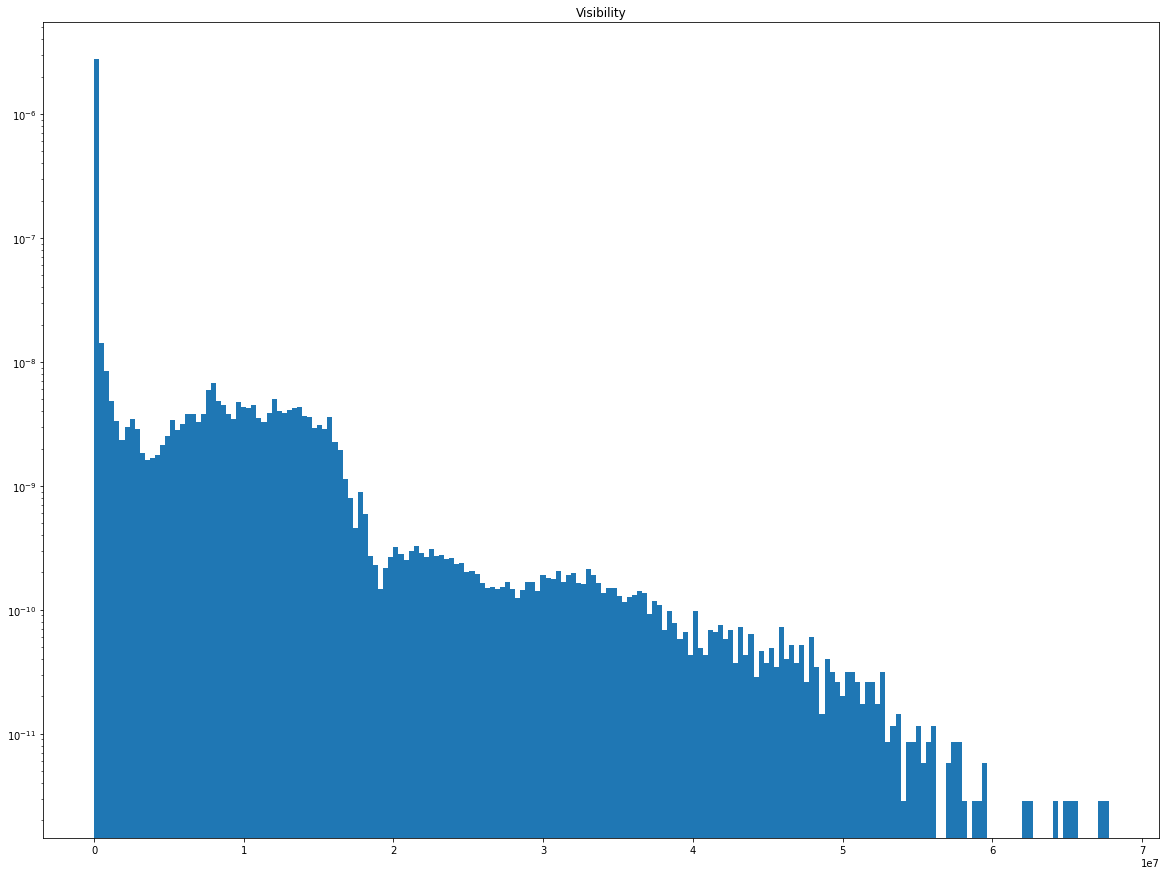

In [52]:
plt.hist(datarr, density = True, bins=200)
plt.yscale('log')
plt.title('Visibility')
plt.show()

### Problem 1

Determine 5sigma threshold

In [53]:
prob5sigma = 1 - 1/(3.5e6)
print('5 Sigma Value',stats.gamma.ppf(q = prob5sigma, a = 1, loc = 0, scale = 1e7))

5 Sigma Value 150682735.2659742


The 5 sigma visibility value for this data distribution is 1.5e8.

### Problem 2

#### Part A

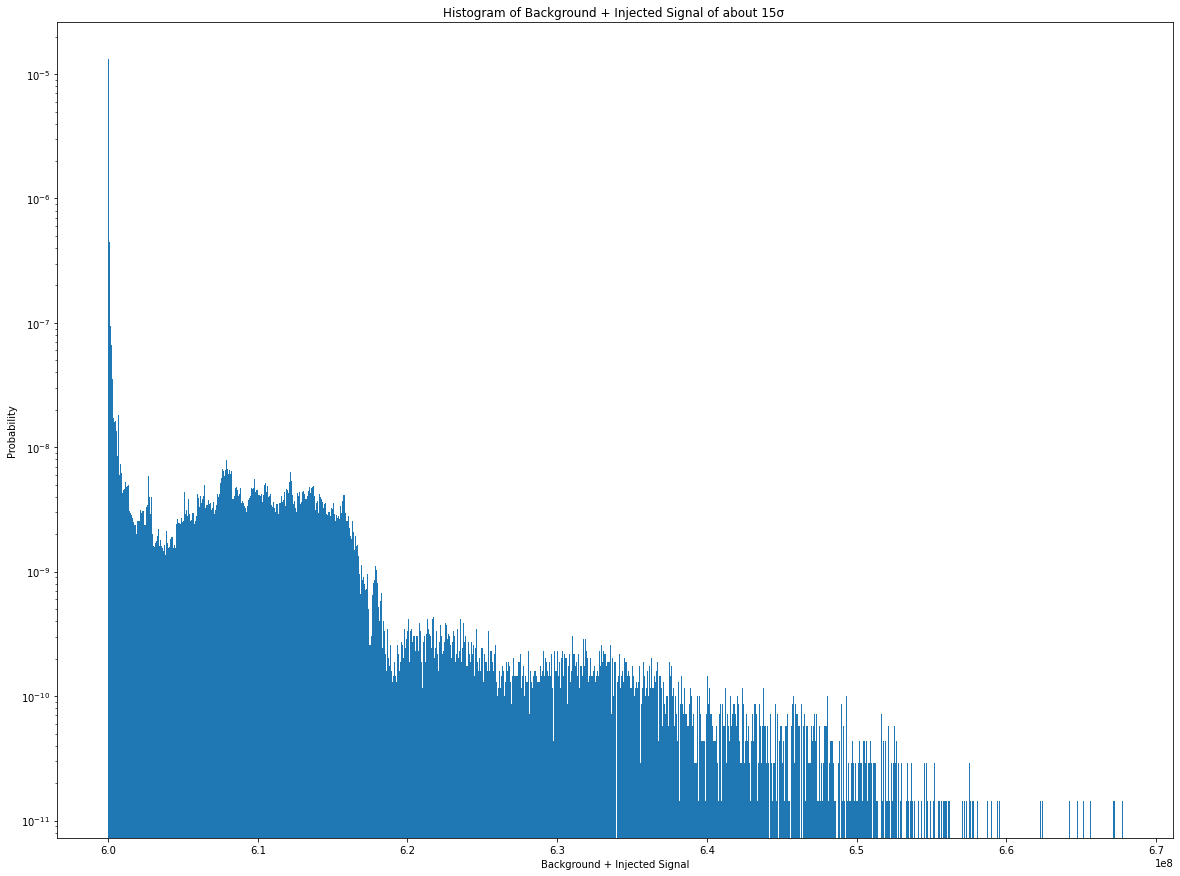

In [55]:
sigknown = 6e8
dat2 = []
for i in range(1022976):
    dat2.append(datarr[i]+sigknown)
plt.hist(dat2, density = True, bins = 1000)
plt.yscale('log')
plt.xlabel('Background + Injected Signal')
plt.ylabel('Probability')
plt.title('Histogram of Background + Injected Signal of about 15σ ')
plt.show()

Is biased since curve is not symmetric

### Problem 3

#### 3a

In [58]:
inject_suite = stats.uniform.rvs(loc=0, scale=prob5sigma*10, size=1000000)

In [62]:
newdata = np.random.choice(datarr,size=50_000)

In [63]:
signal_strengths = np.linspace(0, 30*42970588/5,500)
sha = (np.random.rand(500,newdata.size) < 0.25)#*42970588.40081523*(1/5)

In [64]:
_, signal_strengths_grid = np.meshgrid(sha[0, :], signal_strengths)
signal = sha * signal_strengths_grid

In [65]:
obs = signal+newdata

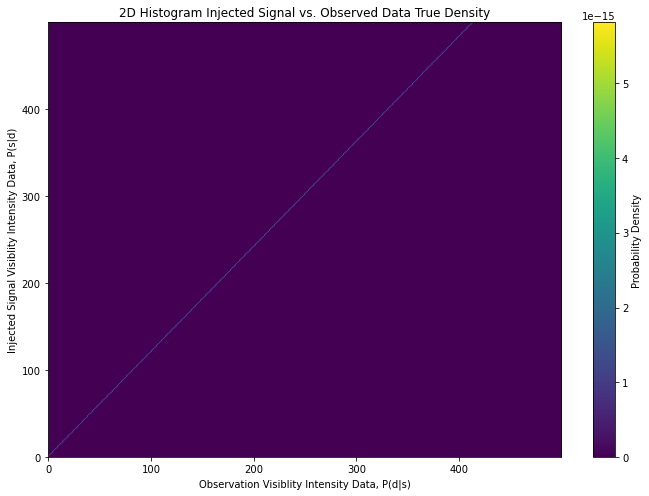

In [66]:
fig,ax=plt.subplots(figsize=(11.5,8))
Psd, temp, temp2=np.histogram2d(obs.flatten(), signal_strengths_grid.flatten(), bins=500, density=True)
plt.imshow(Psd.T,origin='bottom')
#plt.yscale('log')
plt.gca().set_aspect('auto')
plt.colorbar(label='Probability Density')
plt.title('2D Histogram Injected Signal vs. Observed Data True Density')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Injected Signal Visiblity Intensity Data, P(s|d)');

Modifying this plot

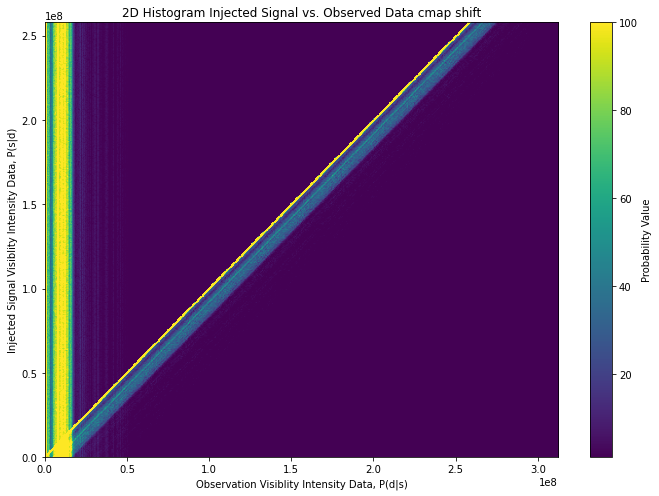

In [67]:
fig,ax=plt.subplots(figsize=(11.5,8))
Psd, temp, temp2=np.histogram2d(obs.flatten(), signal_strengths_grid.flatten(), bins=500)
plt.imshow(Psd.T,origin='bottom',extent=(0, obs.max(), signal_strengths.min(), signal_strengths.max()),vmin=1,vmax=100)
#plt.yscale('log')
plt.gca().set_aspect('auto')
plt.colorbar(label='Probability Value')
plt.title('2D Histogram Injected Signal vs. Observed Data cmap shift')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Injected Signal Visiblity Intensity Data, P(s|d)');

Improving once again

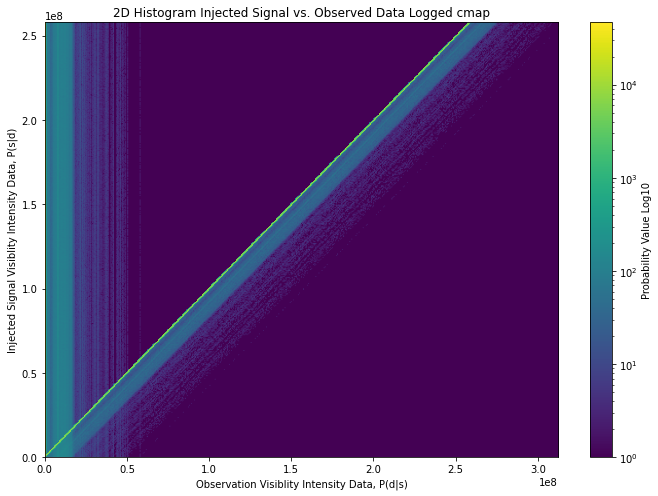

In [68]:
fig,ax=plt.subplots(figsize=(11.5,8))
Psd, temp, temp2=np.histogram2d(obs.flatten(), signal_strengths_grid.flatten(), bins=500)
plt.imshow(Psd.T+1,origin='bottom',extent=(0, obs.max(), signal_strengths.min(), signal_strengths.max()),norm=colors.LogNorm(vmin=1,vmax=Psd.max(),clip=True))
#plt.yscale('log')
plt.gca().set_aspect('auto')
plt.colorbar(label='Probability Value Log10')
plt.title('2D Histogram Injected Signal vs. Observed Data Logged cmap')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Injected Signal Visiblity Intensity Data, P(s|d)');

### 3b

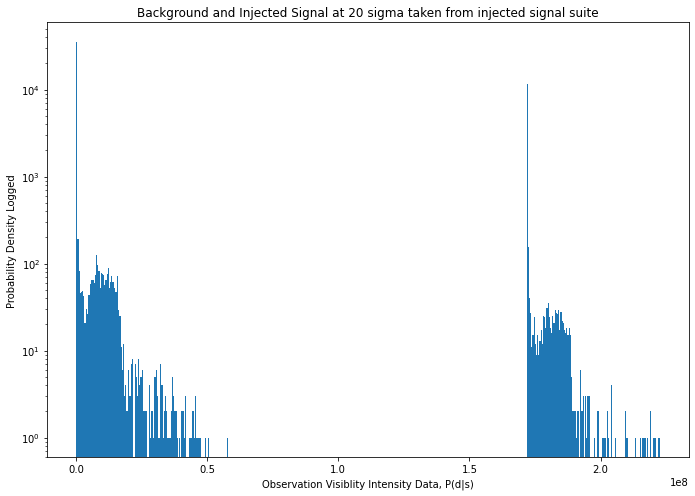

In [69]:
index = abs(signal_strengths - 42970588.40081523*(20/5)).argmin()
vals = obs[index, :]
fig,ax=plt.subplots(figsize=(11.5,8))
plt.yscale('log')
plt.xlabel('Observation Visiblity Intensity Data, P(d|s)')
plt.ylabel('Probability Density Logged')
plt.title('Background and Injected Signal at 20 sigma taken from injected signal suite')
plt.hist(vals,bins=500);

We see here that it emulates the previous plot fairly well. Since we are taking a subset of the data it will not reflect the whole dataset from the previous plot, but we see that the background and the signal are in the same general location and with the same general shape as before.

#### 3c

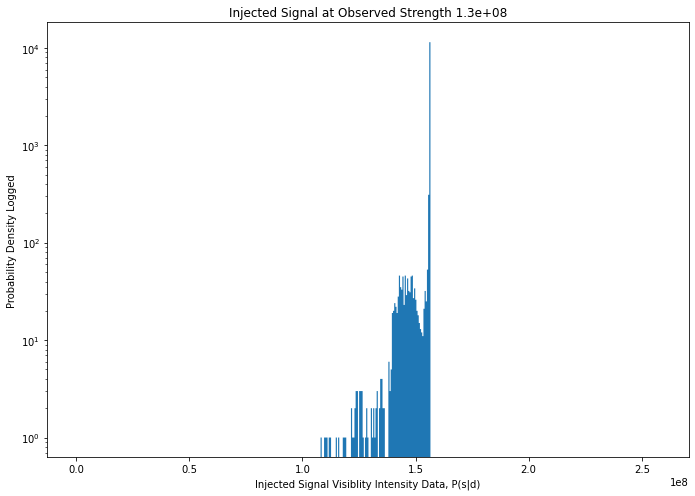

In [70]:
mach=signal_strengths[250]
fig,ax=plt.subplots(figsize=(11.5,8))
ex2=np.linspace(signal_strengths.min(), signal_strengths.max(),500)
plt.yscale('log')
plt.xlabel('Injected Signal Visiblity Intensity Data, P(s|d)')
plt.ylabel('Probability Density Logged')
plt.title(f'Injected Signal at Observed Strength {mach:0.1e}')
plt.fill_between(ex2,Psd[250],step="pre");
#plt.hist(Psd[250],bins=500);

The meaning of this histogram is that given the observed strength 1.3e8, what is the probability of there being an injected signal. We find here that such probability.

#### 3d
Here we are finding the 1 sigma uncertainty of this given probability distribution. We can do this by integrating up to -1 sigma from a normal distribution and then select the greatest fit probability value from this integration, which is the best estimate to a 1-sigma value for this distribution.

In [72]:
mp = Psd[250]
bins = np.linspace(signal_strengths.min(), signal_strengths.max(),50_000)

partial_sums = np.cumsum(mp) / np.sum(mp)
index = np.argmin(abs(partial_sums - stats.norm.cdf(-1)))
out=bins[index - 1]

print(out - bins[np.argmax(mp)])

-10313.147382947616


#### 3e
This value is not symmetric, as stated before, this value is negative since our distribution is not symmetric, but has values that point in the negative direction. It is biased since it is coming from a biased signal distribution. This tells us that our true signal is less than our best estimate that we have found.